In [57]:
import os
import random
import gym
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import imageio
from skimage.transform import resize

import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import sklearn
import skimage
import tensorflow as tf

import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import sklearn
import skimage
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices([], 'GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)])
    except RuntimeError as e:
        print(e)
    
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape, InputLayer
from tensorflow.keras.optimizers import RMSprop
import gym
import matplotlib.pyplot as plt
import sklearn
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from collections import deque

#This checks early execution for tensorflow 2
tf.compat.v1.enable_eager_execution()
tf.keras.backend.clear_session()
print('executing eagerly? ',tf.executing_eagerly())

executing eagerly?  True


In [14]:
keras.backend.clear_session()

In [63]:
def preprocess_Observation(obs):
    obs = np.mean(obs,axis=2).astype(np.uint8)
    obs = obs[::2,::2]
    return obs

def make_DQN(n_outputs=6):
    model = Sequential([
        Conv2D(16,(8,8),activation='relu',strides=(4,4),
               kernel_initializer=keras.initializers.VarianceScaling(scale=2),
               input_shape=(105,80,4,)),
        
        Conv2D(32,(4,4),activation='relu',strides=(2,2),
               kernel_initializer=keras.initializers.VarianceScaling(scale=2)),
        
        Flatten(),
        Dense(256,activation='relu',kernel_initializer=keras.initializers.VarianceScaling(scale=2)),
        Dense(n_outputs)
    ])
    
    return model

def epsilon_greedy_policy(state,model,eps,env):
    if np.random.uniform() < 0:
        action = env.action_space.sample()
        return action
    else:
        Q_vals = model.predict(state[np.newaxis].astype(np.float32))
        print(np.argmax(Q_vals[0]))
        return np.argmax(Q_vals[0])
    

def skip_k_frames(env,action,p_obs):
    obs1, r, done, info = env.step(action)
    obs2, r, done, info = env.step(action)
    obs3, r, done, info = env.step(action)

    p_obs1,p_obs2,p_obs3 = preprocess_Observation(obs1),preprocess_Observation(obs2),preprocess_Observation(obs3)

    p_obs_k = np.stack([p_obs,p_obs1,p_obs2,p_obs3],axis=2).astype(np.uint8)

    return p_obs_k

def sample_experiences(batch_size,replay_buffer):
    indices = np.random.randint(len(replay_buffer),size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    
    return states, actions, rewards, next_states, dones

def play_one_step(env, state,model,replay_buffer, epsilon):
    action = epsilon_greedy_policy(state,model,epsilon,env)
    #print(action)
    next_state, reward, done, info = env.step(action)
    next_state = skip_k_frames(env,action,preprocess_Observation(next_state))
    replay_buffer.append((state,action,reward,next_state,done))
    return next_state, reward, done, info

def training_step(batch_size,replay_buffer,model,target,discount_factor=0.95,loss_fn=keras.losses.mean_squared_error,
                 optimizer=keras.optimizers.Adam(lr=1e-3)):
    experiences = sample_experiences(batch_size,replay_buffer)
    states, actions, rewards, next_states, dones = experiences
    
    next_Q_values = model.predict(next_states.astype(np.float32))
    best_next_actions = np.argmax(next_Q_values,axis=1)
    #print(best_next_actions.shape)
    #print(next_Q_values.shape)
    next_mask = tf.one_hot(best_next_actions,n_outputs).numpy()
    #print(target.predict(next_states.astype(np.float32)).shape)
    next_best_Q_values = (target.predict(next_states.astype(np.float32))*next_mask).sum(axis=1)
    
    target_Q_values = (rewards + (1 - dones) * discount_factor * next_best_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        all_Q_values = model(states.astype(np.float32))
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values,Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    

def generate_gif(frame_number, frames_for_gif, reward, path):
    """
        Args:
            frame_number: Integer, determining the number of the current frame
            frames_for_gif: A sequence of (210, 160, 3) frames of an Atari game in RGB
            reward: Integer, Total reward of the episode that es ouputted as a gif
            path: String, path where gif is saved
    """
    for idx, frame_idx in enumerate(frames_for_gif): 
        frames_for_gif[idx] = resize(frame_idx, (420, 320, 3), 
                                     preserve_range=True, order=0).astype(np.uint8)
        
    imageio.mimsave(f'{path}{"ATARI_frame_{0}_reward_{1}.gif".format(frame_number, reward)}', 
                    frames_for_gif, duration=1/30)

In [64]:
batch_size=32
discount_factor = 0.99
decay_rate = 0.99
optimizer = keras.optimizers.RMSprop(lr=0.00025,rho=0.95,epsilon=0.01)
loss_fn = keras.losses.mean_squared_error
Max_n_frames = 10000000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
eps_decay_lim = 1000000
free_exploration_lim = 50000
env = gym.make('PongDeterministic-v4')
input_shape = [4]
n_outputs = 6

replay_buffer = deque(maxlen=int(300000))
reward_history = []

model = make_DQN(n_outputs)
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

current_frame = 0
best_score = -10000

for episode in range(30000):
    episode_reward = 0
    if episode%100 == 0 and episode > 0:
        print(episode)
        print(len(replay_buffer))
        print(current_frame)
        print(reward_history[-1])
    
    episode_start_frame=current_frame
    episode_frames = []
    
    obs = env.reset()
    obs = preprocess_Observation(obs)
    obs = skip_k_frames(env,1,obs)
    
    episode_frames.append(obs[:,:,-1])
    
    for step in range(1000):
        #print('step')
        current_frame += 1
        if current_frame < free_exploration_lim:
            epsilon= 1
        else:
            epsilon = max(1 - current_frame / eps_decay_lim, 0.01)
        
        obs, reward, done, info = play_one_step(env,obs,model,replay_buffer,epsilon)
        episode_frames.append(obs[:,:,-1])
        if done:
            break
        if current_frame > 50 and current_frame%4==0:
            training_step(batch_size,replay_buffer,model,target,discount_factor,loss_fn,optimizer)
        
        
        if current_frame%10000==0:
            target.set_weights(model.get_weights())
            
        episode_reward += reward
            
    reward_history.append(episode_reward)
    
    if episode%200==0:
        generate_gif(current_frame,episode_frames,episode_reward,'training_test')
    
    if episode_reward > best_score:
        best_weights = model.get_weights()
        model.save_weights('pong_linear_test_weights.hdf5')
        best_score = episode_reward
    
    if current_frame > Max_n_frames:
        break


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
2
5
5
5
5
5
2
2
2
2
5
5
2
5
2
2
2
2
5
5
5
5
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
5
5
5
5
5
5
5
5
4
4
4
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
2
4
4
4
2
5
5
5
4
4
4
4
4
4
4
4
4
2
4
4
2
2
2
2
5
5
2
5
2
2
2
2
2
2
2
2
5
5
5
5
2
5
5
5
5
5
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
2
2
2
2
5
5
5
5
4
4
4
4
4
4
4
4
4
4
4
4
2
2
4
4
2
2
5
4
5
5
5
5
2
4
2
2
4
2
2
2
5
4
4
5
5
5
5
5
4
5
5
5
2
5
5
4
5
5
5
4
5
5
2
5
5
5
5
5
2
2
2
2
4
4
4
2
5
4
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
4
5
5
2
2
5
2
5
4
5
4
4
4
4
4
2
2
2
2
4
4
4
4
2
2
2
2
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
4
4
5
4
4
4
5
4
4
4
4
2
5
4
2
4
4
4
4
4
4
4
4
4
2
2
2
5
5
5
5
4
5
4
4


KeyboardInterrupt: 

In [62]:
model.trainable_variables

[<tf.Variable 'conv2d_2_1/kernel:0' shape=(8, 8, 4, 16) dtype=float32, numpy=
 array([[[[-6.90625235e-02, -9.16489735e-02, -3.68381590e-02, ...,
           -1.59530099e-02,  1.28001437e-01, -4.57722433e-02],
          [-2.03495398e-02,  5.58141135e-02,  5.92968650e-02, ...,
           -3.15907784e-02,  1.07844740e-01, -3.60706560e-02],
          [-4.51648310e-02, -3.46104018e-02, -5.54452501e-02, ...,
            2.34564900e-01,  7.62739629e-02, -1.13848634e-01],
          [-6.95579648e-02,  6.93768710e-02,  1.34562492e-01, ...,
            3.19450200e-01, -1.38961568e-01, -1.28124217e-02]],
 
         [[-5.87341785e-02, -9.31033120e-03, -4.93317954e-02, ...,
            6.28727674e-02, -1.38424546e-01,  5.84002957e-02],
          [-3.77192278e-03, -1.16853274e-01, -5.03875613e-02, ...,
            2.30084836e-01,  1.00195736e-01, -8.30879733e-02],
          [ 6.18486106e-02, -1.62392572e-01, -1.05177552e-01, ...,
            1.43112123e-01,  8.38620365e-02,  1.11673765e-01],
         

In [26]:
model.set_weights(best_weights)

In [30]:
experiences = sample_experiences(1,replay_buffer)

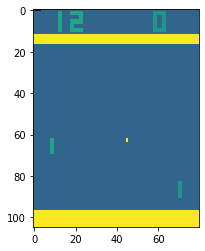

In [38]:
plt.imshow(experiences[0].squeeze()[:,:,3])

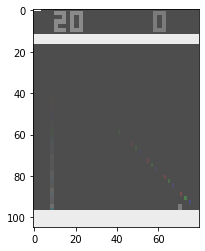

In [28]:
import time
obs = env.reset()
obs = preprocess_Observation(obs)
obs = skip_k_frames(env,1,obs)
#print(env.action_space())
for step in range(800):
    time.sleep(0.01)
    env.render()
    epsilon=0.01
    if step > 100:
        plt.imshow(obs,cmap='gray')
    obs,reward,done,info = play_one_step(env,obs,model,replay_buffer,epsilon)

    #print(reward)
    #print(obs)
    if done:
        break
env.close()

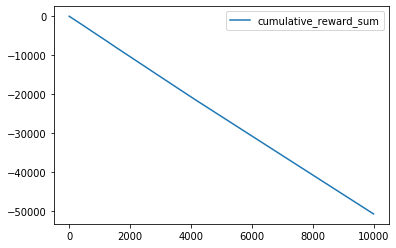

<Figure size 432x288 with 0 Axes>

In [9]:
plt.plot(np.cumsum(reward_history),label='cumulative_reward_sum')
plt.legend()
plt.show()
plt.savefig('cumsum_reward_history_2m.png')

(105, 80)

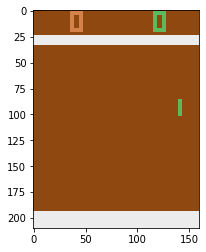